# Problem description
This project task is to find frames with people from a security camera video. The project idea is from my former company working experience. My former company is a factory, and there are a lot of security cameras in the factory. One day, a manager found someone hide a box of not good products in a corner at night, the manager wanted to find who does this. He needs to check the recorded video, but the video was long, last for about 10 hours. It was very time consuming. I want to use machine learning to solve this problem, filtering out the frames without people, then manager only check the frames with people. Most frames have nobody inside. It’s benefit is to save manager time. It is an unsupervised machine learning problem, for evaluation, I watch the whole video to compare the machine learning result.
The dataset is in kaggle.
https://www.kaggle.com/chunshanfeng/security-camera-video

# Roadmap
The project road map. First step, extracting frames from video. Then I tried two methods to solve this problem. 
Solution one, using image clustering method.
Solution two, calculating the neighbouring images similarity.

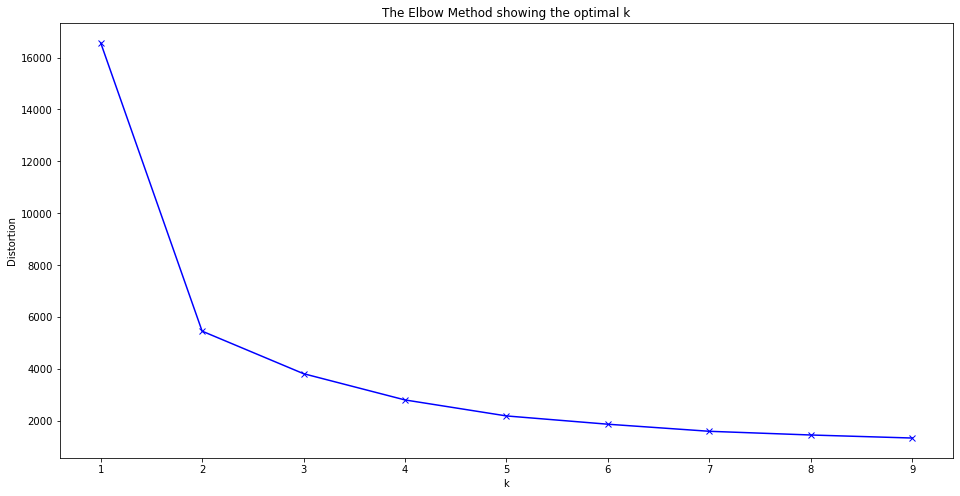

In [1]:
import cv2
import os
import datetime
import time
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

# create a folder to save frames
import os
if not os.path.exists('image'):
    os.makedirs('image')

# read the video    
vidcap = cv2.VideoCapture('security.mp4')

# result is dataframe to save frames
result=pd.DataFrame()
diff=[]

# if the folder 'image' has files, then delete them
dir = 'image'
for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))
 

def getFrame(sec):
    # this function get frames from video
    global result,diff
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img=gray
        width=128
        height=72
            
        dim = (width, height)

        seconds=sec
        hours = seconds // (60*60)
        seconds %= (60*60)
        minutes = seconds // 60
        seconds %= 60

            # resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        image=resized 
        image=image/255
        vectorized = image.reshape((1,-1))

        df=pd.DataFrame(vectorized)
        file="image-"+ str(hours) +"h" + str(minutes) +"m" +str(seconds)+"s.jpg"

        df.insert(0, "frame", file)
        if len(diff)==0:
            diff2=0
            diff.append(image)
        else:
            lastimage=diff[-1]
            
            difference = cv2.subtract(lastimage, image)
            diff2= np.sum(difference**2)
            diff2=np.sqrt(diff2)
            diff.append(image)
        df.insert(1, "difference", diff2)
        frames = [result, df]
        result = pd.concat(frames, ignore_index=True)
        path = 'image'

        image=image*255
        cv2.imwrite(os.path.join(path, "image-"+ str(hours) +"h" + str(minutes) +"m" +str(seconds)+"s.jpg"), image)
         
    return hasFrames

sec = 0
frameRate = 1   #//it will capture image in each 1 second
count=1

success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

# We run K-means with a fixed number of clusters. In our case 4.
result2=result.drop(['frame','difference'], axis=1)


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(result2)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
# We divide our data into the seven clusters.
kmeans.fit(result2)
# We create a new data frame with the original features and add a new column with the assigned clusters for each point.
df_segm_kmeans = result.copy()
#df_segm_kmeans['Segment K-means'] = kmeans.labels_
df_segm_kmeans.insert(2,"k-means",kmeans.labels_)

# save both the image clustering result and neighbouring similarity result to result.csv file
df1 = df_segm_kmeans[['frame','difference','k-means']]
df1.to_csv('result.csv')

The challenge for K-means cluster is to find the clusters number. For this problem, I need use our domain knowledge. Elbow method does not work well in this problem. If using elbow method, it seems we should choose clusters number two, actually two is not a good choice.

Let’s see the result. This chart shows the result of image clustering evaluation. I use F1 score to evaluate different cluster result. From the result, we know two clusters is not good choice. Five and Six clusters have little improvement than three and four clusters.
![image clustering evaluation](https://user-images.githubusercontent.com/32756270/150694726-c28d388c-e489-4d2a-bab5-bac378b9333a.png)


<AxesSubplot:>

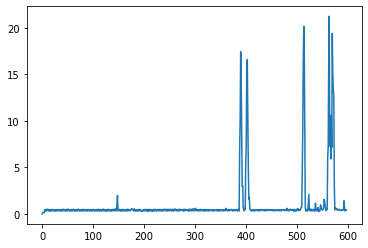

In [6]:
df_line=df1['difference']
df_line.plot.line()

This chart shows the result of image similarity calculation. I use euclidean distance to calculate the neighbouring images similarity. If distance is small, it means neighbouring images are similar,  no motion between the images. If distance is large, it means  neighbouring images are not similar, there is person movement in the video. These three high distance area is the images with people. Choosing the images which distance over 3, this method accuracy is 99 percent. 

# Conclusion
Comparing the two methods, I think calculating images distance is better, it needn’t face the challenge to choose cluster number.